In [ ]:
## Notebook env: brian_script_env (R kernel)

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggforce))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr))

In [2]:
## load ESTIMATE scores -- high ESTIMATE score = lower tumor purity
ESTIMATE_scores = read.csv('/home/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/ESTIMATE_scores.tsv', sep = '\t')
ESTIMATE_scores$ID = str_replace_all(ESTIMATE_scores$ID, '-', '.')

## load patient metadata
meta = read.csv('/home/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_bcr_clinical_data_patient.txt', skip = 4, sep='\t')
RNA_Seq_expression_raw_data <- read.delim("/home/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_RNA_Seq_v2_expression_median.txt", stringsAsFactors = FALSE)

## NOTE: order of patients in ESTIMATE_scores and RNA_Seq_expression_raw_data is the same
identical(RNA_Seq_expression_raw_data %>% select(-c(1,2)) %>% colnames(), ESTIMATE_scores$ID)

## combined dfs with ESTIMATE scores and CO exp
ESTIMATE_scores_w_CO_exp = cbind(ESTIMATE_scores, 
RNA_Seq_expression_raw_data %>% select(-Entrez_Gene_Id) %>% filter(Hugo_Symbol == 'RNF8') %>% select(-Hugo_Symbol) %>% t() %>% as.data.frame() %>% `colnames<-`('RNF8_exp'),
RNA_Seq_expression_raw_data %>% select(-Entrez_Gene_Id) %>% filter(Hugo_Symbol == 'MIS18A') %>% select(-Hugo_Symbol) %>% t() %>% as.data.frame() %>% `colnames<-`('MIS18A_exp'))

ESTIMATE_scores_w_CO_exp_and_quantiles = ESTIMATE_scores_w_CO_exp %>% mutate(RNF8_q25_q75_quantile = case_when(if_all(RNF8_exp, function(x) x <= quantile(x, .25)) ~ 'q25', if_all(RNF8_exp, function(x) x >= quantile(x, .75)) ~ 'q75', TRUE ~ 'neither')) %>% 
mutate(MIS18A_q25_q75_quantile = case_when(if_all(MIS18A_exp, function(x) x <= quantile(x, .25)) ~ 'q25', if_all(MIS18A_exp, function(x) x >= quantile(x, .75)) ~ 'q75', TRUE ~ 'neither')) %>% 
mutate(RNF8_q10_q90_quantile = case_when(if_all(RNF8_exp, function(x) x <= quantile(x, .10)) ~ 'q10', if_all(RNF8_exp, function(x) x >= quantile(x, .90)) ~ 'q90', TRUE ~ 'neither')) %>% 
mutate(MIS18A_q10_q90_quantile = case_when(if_all(MIS18A_exp, function(x) x <= quantile(x, .10)) ~ 'q10', if_all(MIS18A_exp, function(x) x >= quantile(x, .90)) ~ 'q90', TRUE ~ 'neither'))

head(ESTIMATE_scores_w_CO_exp_and_quantiles)

[1] TRUE

,ID,Stromal_score,Immune_score,ESTIMATE_score,RNF8_exp,MIS18A_exp,RNF8_q25_q75_quantile,MIS18A_q25_q75_quantile,RNF8_q10_q90_quantile,MIS18A_q10_q90_quantile
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
TCGA.3C.AAAU.01,TCGA.3C.AAAU.01,-711.41,-906.98,-1618.39,591.4345,280.8969,q75,neither,neither,neither
TCGA.3C.AALI.01,TCGA.3C.AALI.01,122.66,511.24,633.91,236.5416,275.6933,q25,neither,q10,neither
TCGA.3C.AALJ.01,TCGA.3C.AALJ.01,400.91,539.25,940.16,165.9112,207.6156,q25,q25,q10,neither
TCGA.3C.AALK.01,TCGA.3C.AALK.01,799.11,-3.53,795.58,206.0405,218.8664,q25,q25,q10,neither
TCGA.4H.AAAK.01,TCGA.4H.AAAK.01,1075.36,-46.96,1028.40,388.0851,307.2340,neither,neither,neither,neither
TCGA.5L.AAT0.01,TCGA.5L.AAT0.01,971.58,665.64,1637.22,350.1980,273.9405,neither,neither,neither,neither


### All patients included ###

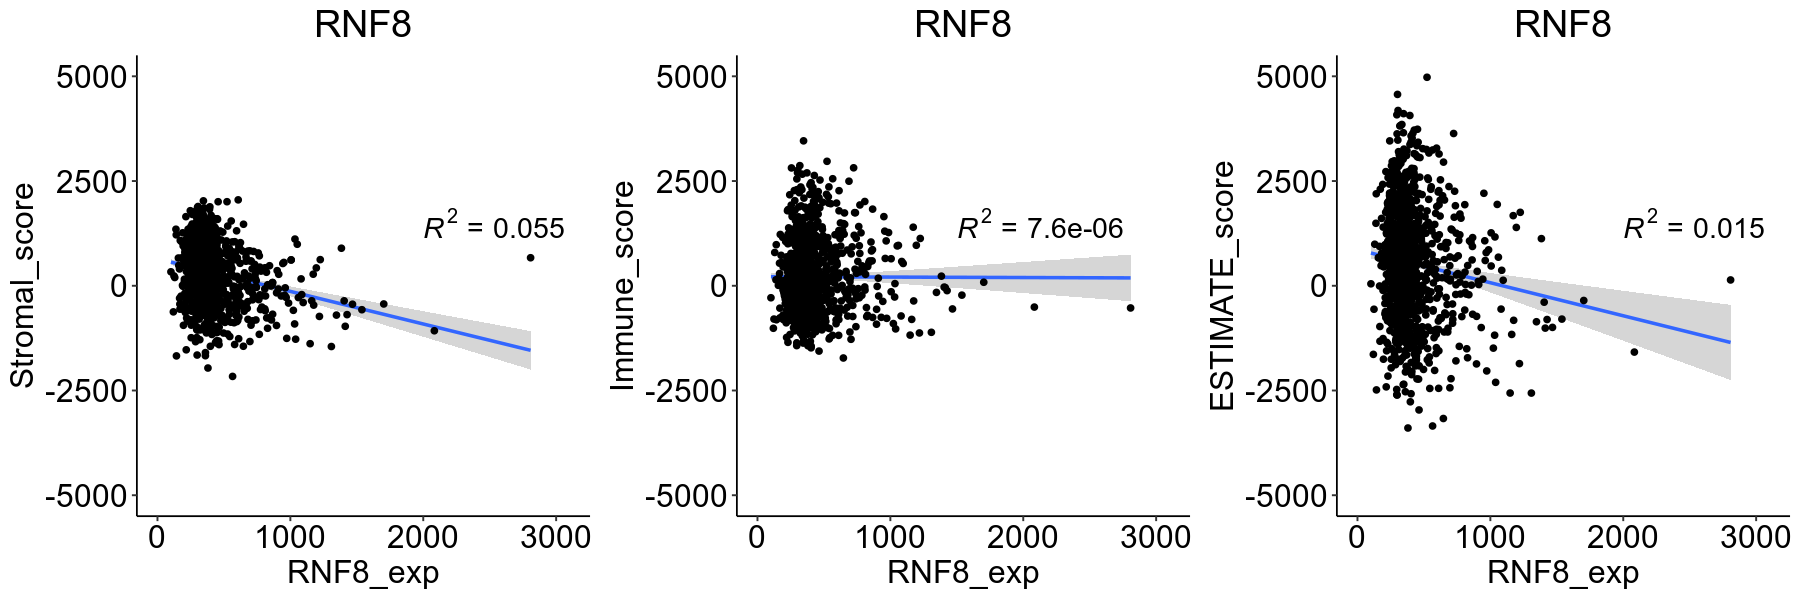

In [3]:
options(repr.plot.width=15, repr.plot.height=5)

plot1 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% select(RNF8_exp, Stromal_score) %>% ggplot(aes(x = RNF8_exp, y = Stromal_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 2000, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8')

plot2 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% select(RNF8_exp, Immune_score) %>% ggplot(aes(x = RNF8_exp, y = Immune_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 1500, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8')

plot3 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% select(RNF8_exp, ESTIMATE_score) %>% ggplot(aes(x = RNF8_exp, y = ESTIMATE_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 2000, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8')

ggarrange(plot1, plot2, plot3, ncol = 3)

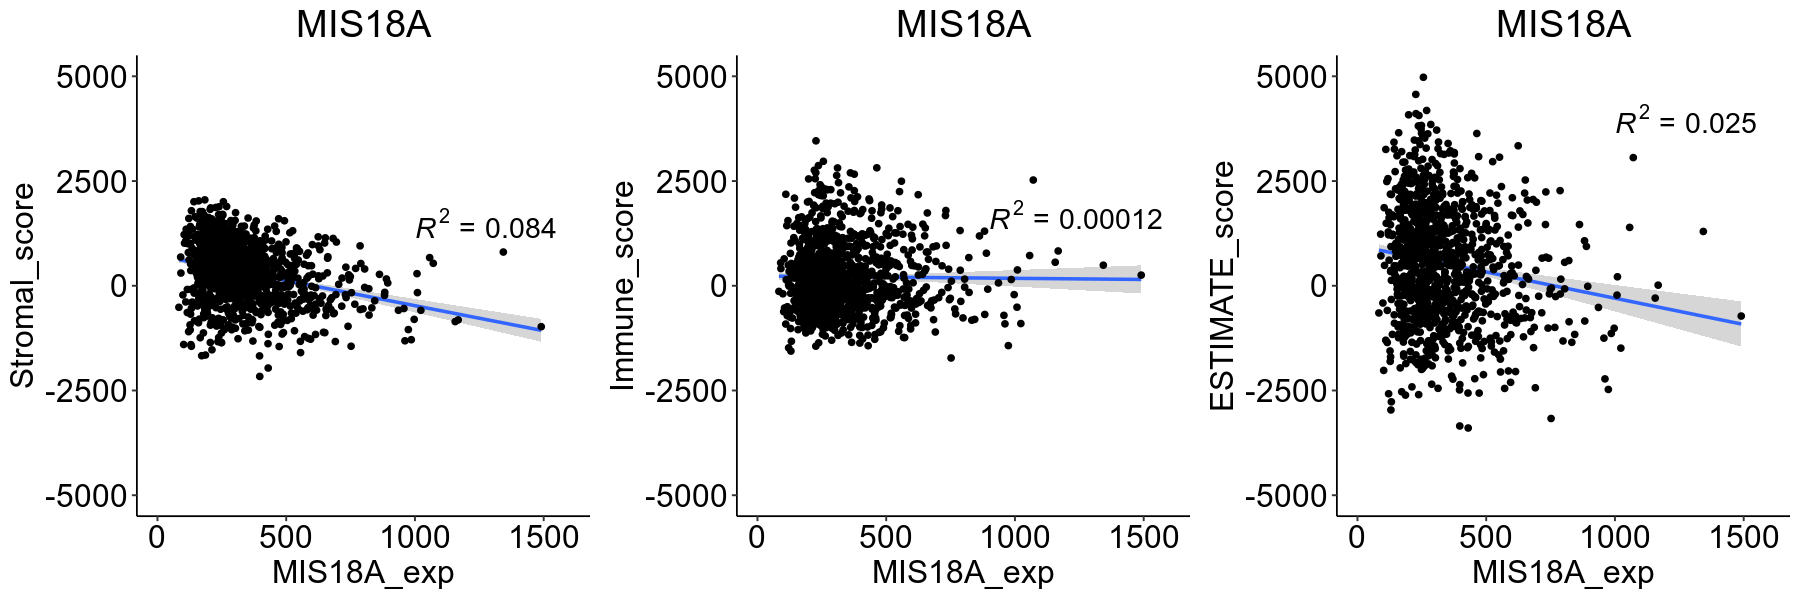

In [4]:
options(repr.plot.width=15, repr.plot.height=5)

plot1 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% select(MIS18A_exp, Stromal_score) %>% ggplot(aes(x = MIS18A_exp, y = Stromal_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 1000, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 1600)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A')

plot2 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% select(MIS18A_exp, Immune_score) %>% ggplot(aes(x = MIS18A_exp, y = Immune_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1700, label.x = 900, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 1600)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A')

plot3 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% select(MIS18A_exp, ESTIMATE_score) %>% ggplot(aes(x = MIS18A_exp, y = ESTIMATE_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 4000, label.x = 1000, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 1600)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A')

ggarrange(plot1, plot2, plot3, ncol = 3)

### q25/q75 patients only ###

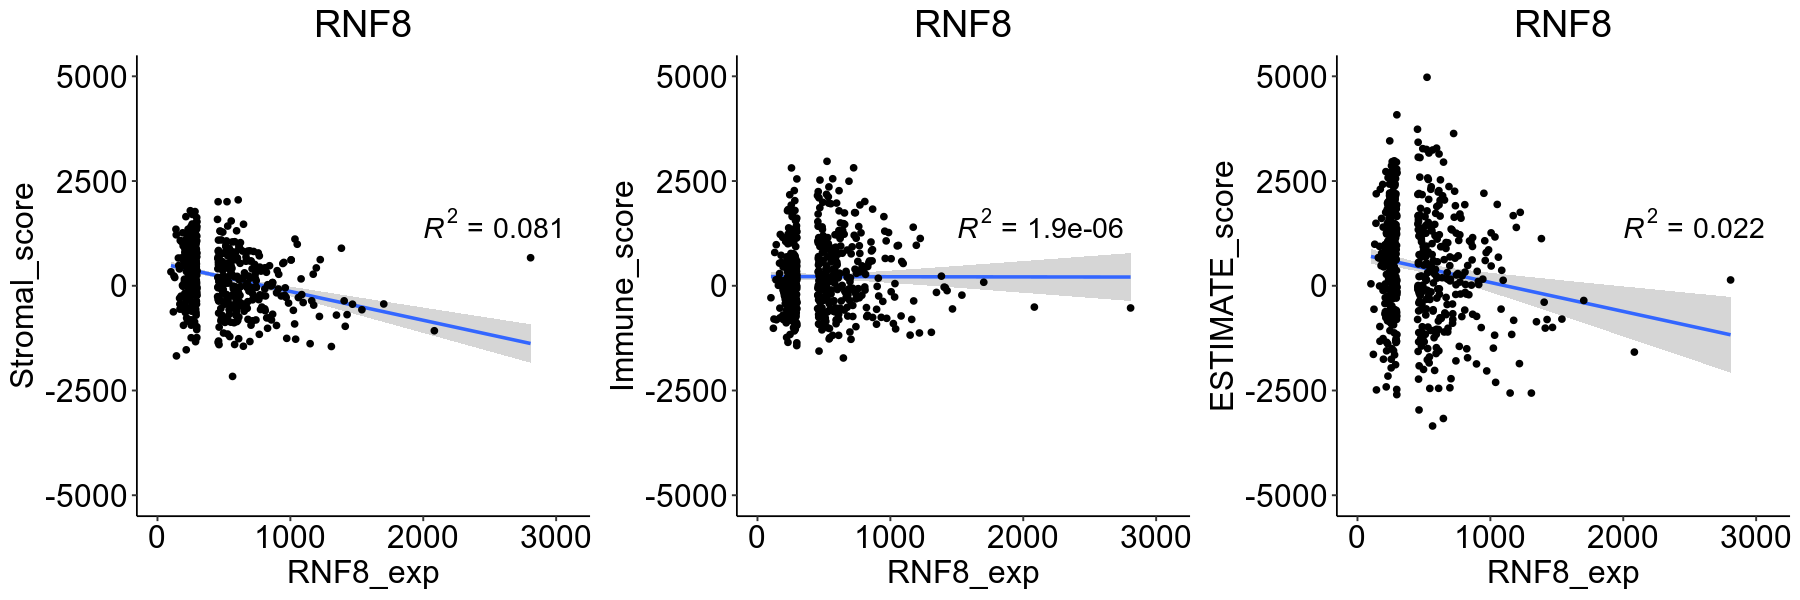

In [5]:
options(repr.plot.width=15, repr.plot.height=5)

plot1 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(RNF8_q25_q75_quantile != 'neither') %>% select(RNF8_exp, Stromal_score) %>% ggplot(aes(x = RNF8_exp, y = Stromal_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 2000, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8')

plot2 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(RNF8_q25_q75_quantile != 'neither') %>% select(RNF8_exp, Immune_score) %>% ggplot(aes(x = RNF8_exp, y = Immune_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 1500, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8')

plot3 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(RNF8_q25_q75_quantile != 'neither') %>% select(RNF8_exp, ESTIMATE_score) %>% ggplot(aes(x = RNF8_exp, y = ESTIMATE_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 2000, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8')

ggarrange(plot1, plot2, plot3, ncol = 3)

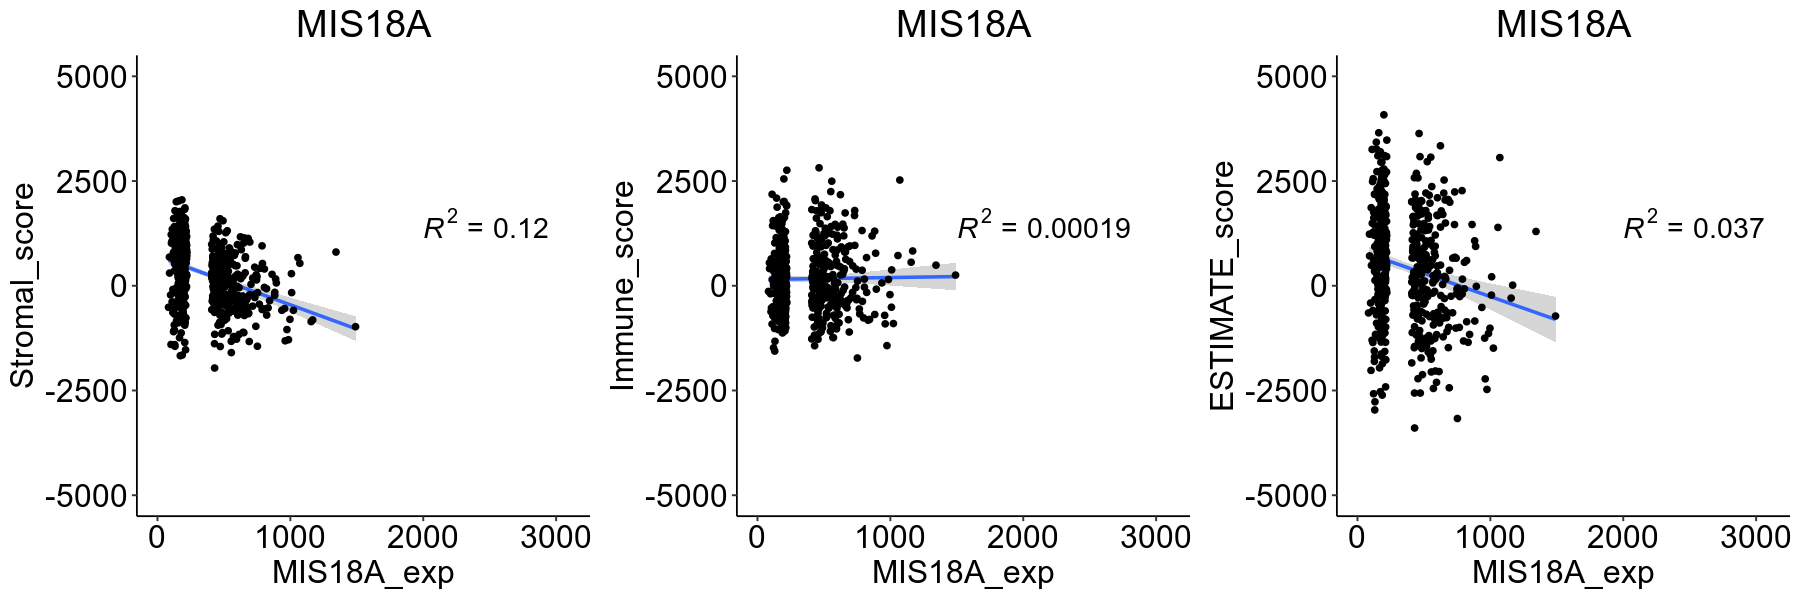

In [6]:
options(repr.plot.width=15, repr.plot.height=5)

plot1 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(MIS18A_q25_q75_quantile != 'neither') %>% select(MIS18A_exp, Stromal_score) %>% ggplot(aes(x = MIS18A_exp, y = Stromal_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 2000, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A')

plot2 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(MIS18A_q25_q75_quantile != 'neither') %>% select(MIS18A_exp, Immune_score) %>% ggplot(aes(x = MIS18A_exp, y = Immune_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 1500, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A')

plot3 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(MIS18A_q25_q75_quantile != 'neither') %>% select(MIS18A_exp, ESTIMATE_score) %>% ggplot(aes(x = MIS18A_exp, y = ESTIMATE_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 2000, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A')

ggarrange(plot1, plot2, plot3, ncol = 3)

In [17]:
saveRDS(ESTIMATE_scores_w_CO_exp_and_quantiles, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig1/ESTIMATE_scores_w_CO_exp_and_quantiles_q25_q75.rds')

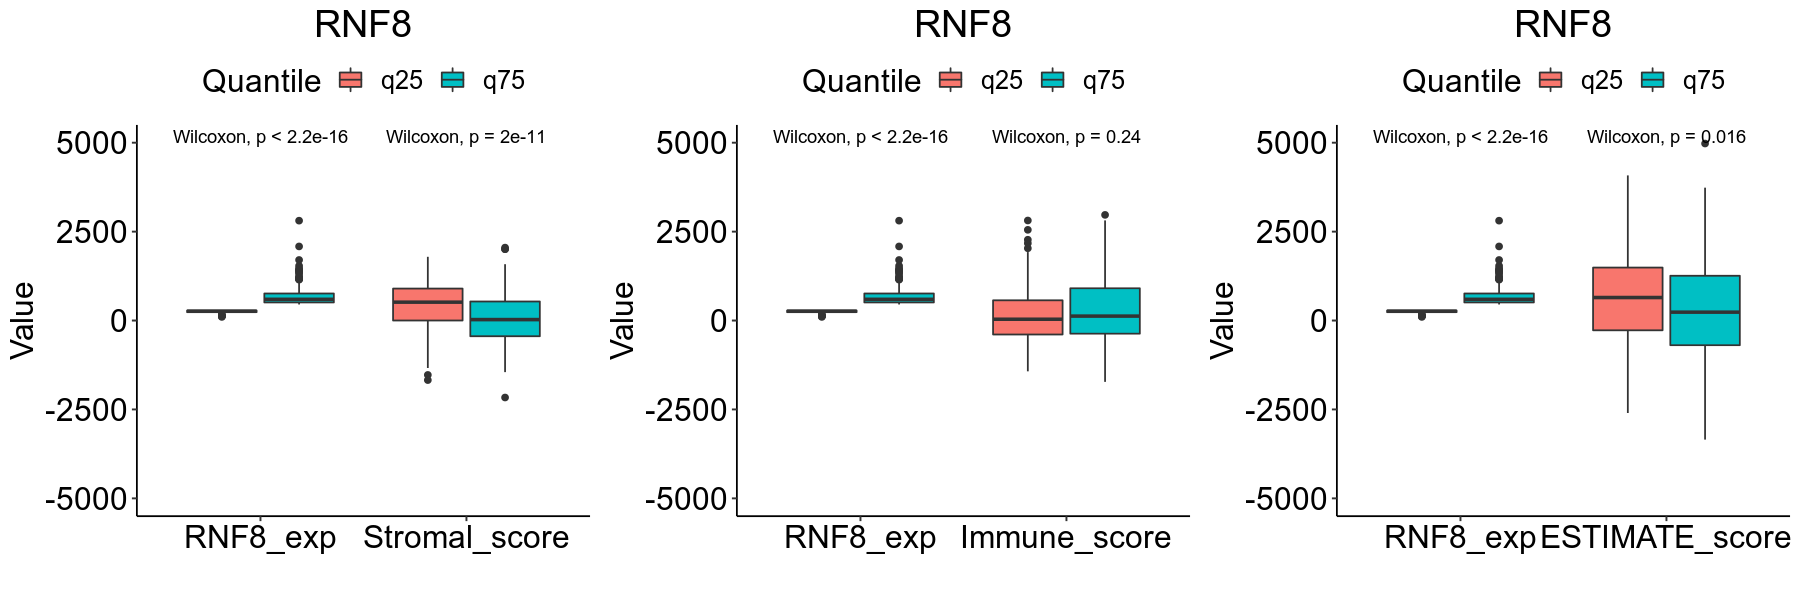

In [ ]:
options(repr.plot.width=15, repr.plot.height=5)
plot1 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(RNF8_q25_q75_quantile != 'neither') %>% select(RNF8_exp, Stromal_score, RNF8_q25_q75_quantile) %>% pivot_longer(cols = -RNF8_q25_q75_quantile, names_to = 'score', values_to = 'value') %>% mutate(score = factor(score, levels = c('RNF8_exp', 'Stromal_score'))) %>% ggplot(aes(x = score, y = value, fill = RNF8_q25_q75_quantile)) + geom_boxplot() + theme_pubr() + theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8') + ylim(-5000, 5000) + stat_compare_means(method = 'wilcox') + guides(fill = guide_legend(title="Quantile")) + xlab('') + ylab('Value')
plot2 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(RNF8_q25_q75_quantile != 'neither') %>% select(RNF8_exp, Immune_score, RNF8_q25_q75_quantile) %>% pivot_longer(cols = -RNF8_q25_q75_quantile, names_to = 'score', values_to = 'value') %>% mutate(score = factor(score, levels = c('RNF8_exp', 'Immune_score'))) %>% ggplot(aes(x = score, y = value, fill = RNF8_q25_q75_quantile)) + geom_boxplot() + theme_pubr() + theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8') + ylim(-5000, 5000) + stat_compare_means(method = 'wilcox') + guides(fill = guide_legend(title="Quantile")) + xlab('') + ylab('Value')
plot3 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(RNF8_q25_q75_quantile != 'neither') %>% select(RNF8_exp, ESTIMATE_score, RNF8_q25_q75_quantile) %>% pivot_longer(cols = -RNF8_q25_q75_quantile, names_to = 'score', values_to = 'value') %>% mutate(score = factor(score, levels = c('RNF8_exp', 'ESTIMATE_score'))) %>% ggplot(aes(x = score, y = value, fill = RNF8_q25_q75_quantile)) + geom_boxplot() + theme_pubr() + theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8') + ylim(-5000, 5000) + stat_compare_means(method = 'wilcox') + guides(fill = guide_legend(title="Quantile")) + xlab('') + ylab('Value')
ggarrange(plot1, plot2, plot3, ncol = 3)

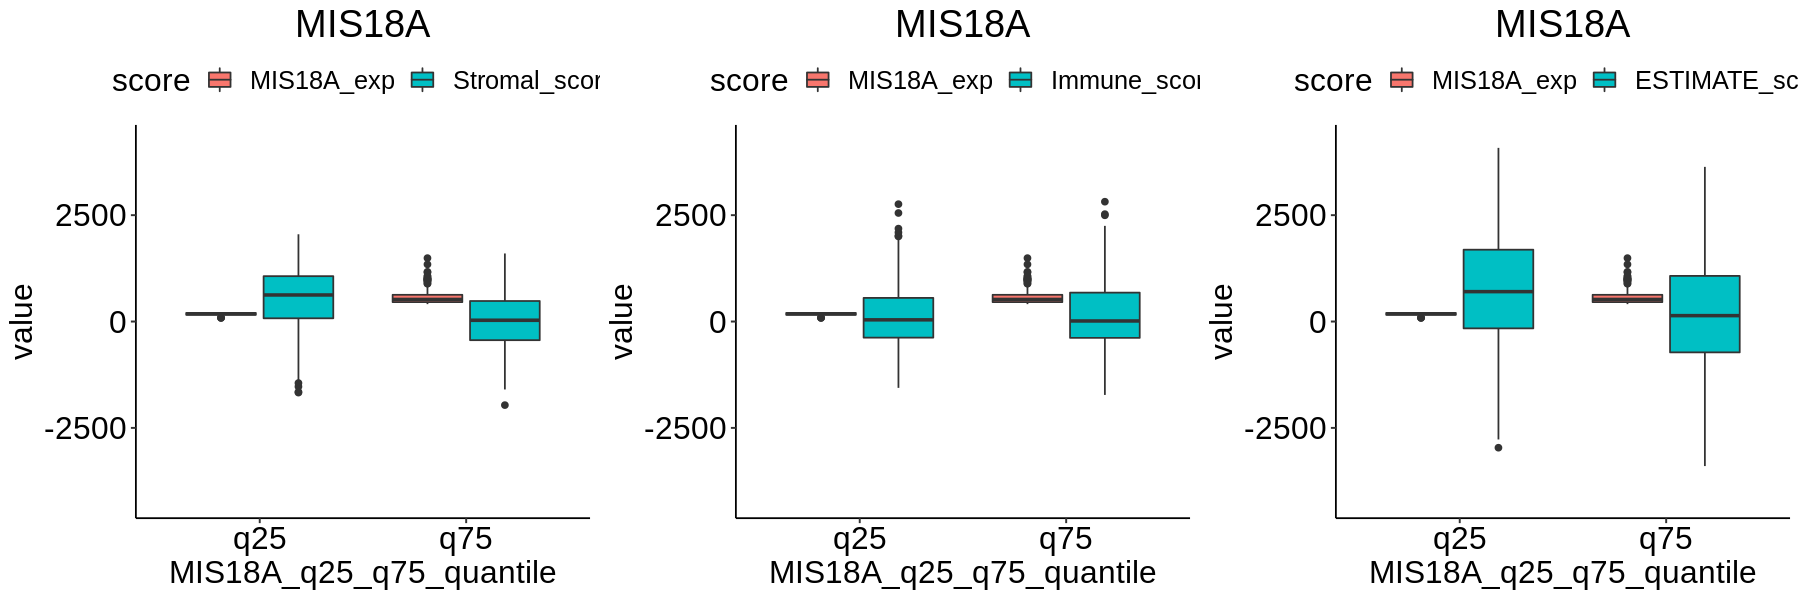

In [115]:
options(repr.plot.width=15, repr.plot.height=5)
plot1 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(MIS18A_q25_q75_quantile != 'neither') %>% select(MIS18A_exp, Stromal_score, MIS18A_q25_q75_quantile) %>% pivot_longer(cols = -MIS18A_q25_q75_quantile, names_to = 'score', values_to = 'value') %>% mutate(score = factor(score, levels = c('MIS18A_exp', 'Stromal_score'))) %>% ggplot(aes(x = MIS18A_q25_q75_quantile, y = value, fill = score)) + geom_boxplot() + theme_pubr() + theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A') + ylim(-4200, 4200)
plot2 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(MIS18A_q25_q75_quantile != 'neither') %>% select(MIS18A_exp, Immune_score, MIS18A_q25_q75_quantile) %>% pivot_longer(cols = -MIS18A_q25_q75_quantile, names_to = 'score', values_to = 'value') %>% mutate(score = factor(score, levels = c('MIS18A_exp', 'Immune_score'))) %>% ggplot(aes(x = MIS18A_q25_q75_quantile, y = value, fill = score)) + geom_boxplot() + theme_pubr() + theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A') + ylim(-4200, 4200)
plot3 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(MIS18A_q25_q75_quantile != 'neither') %>% select(MIS18A_exp, ESTIMATE_score, MIS18A_q25_q75_quantile) %>% pivot_longer(cols = -MIS18A_q25_q75_quantile, names_to = 'score', values_to = 'value') %>% mutate(score = factor(score, levels = c('MIS18A_exp', 'ESTIMATE_score'))) %>% ggplot(aes(x = MIS18A_q25_q75_quantile, y = value, fill = score)) + geom_boxplot() + theme_pubr() + theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A') + ylim(-4200, 4200)
ggarrange(plot1, plot2, plot3, ncol = 3)

### q10/q90 patients only ###

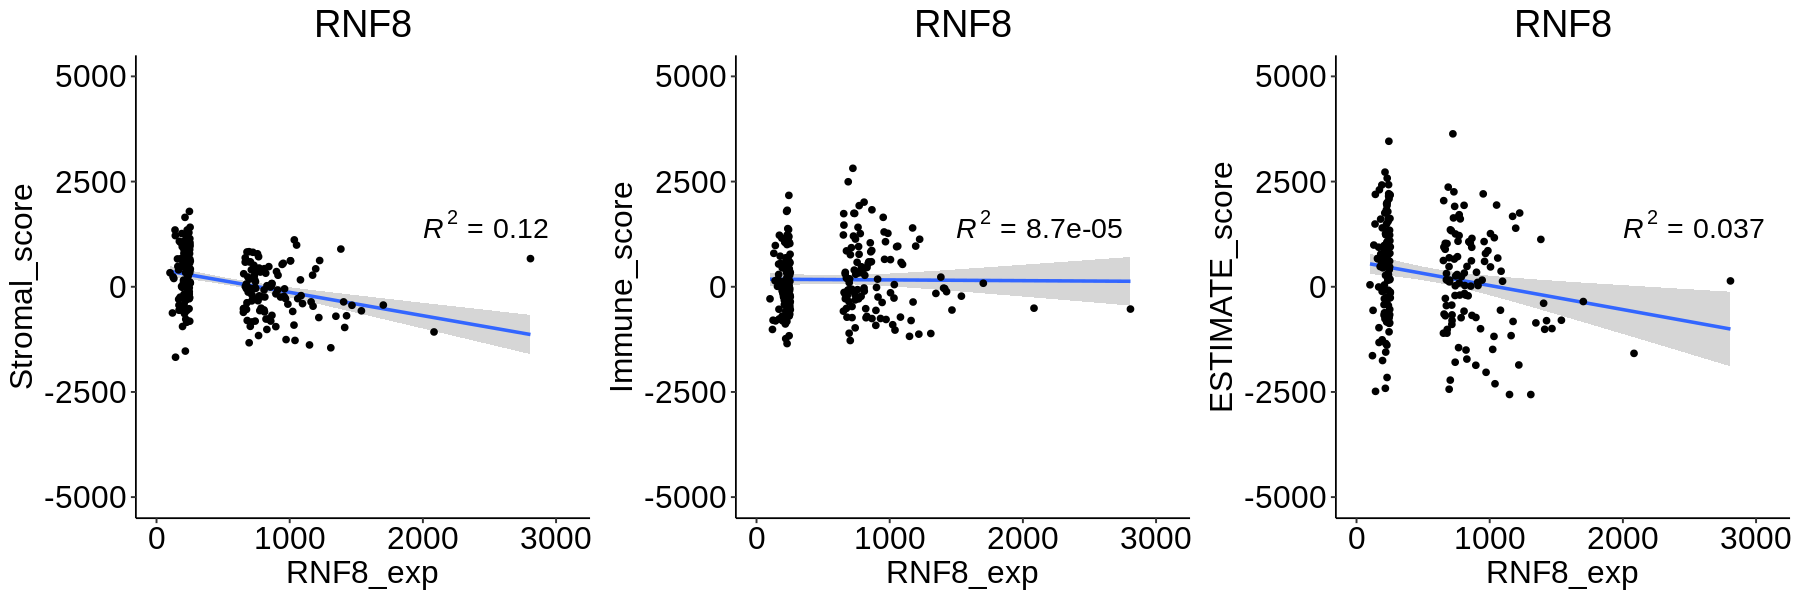

In [105]:
options(repr.plot.width=15, repr.plot.height=5)

plot1 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(RNF8_q10_q90_quantile != 'neither') %>% select(RNF8_exp, Stromal_score) %>% ggplot(aes(x = RNF8_exp, y = Stromal_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 2000, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8')

plot2 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(RNF8_q10_q90_quantile != 'neither') %>% select(RNF8_exp, Immune_score) %>% ggplot(aes(x = RNF8_exp, y = Immune_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 1500, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8')

plot3 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(RNF8_q10_q90_quantile != 'neither') %>% select(RNF8_exp, ESTIMATE_score) %>% ggplot(aes(x = RNF8_exp, y = ESTIMATE_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 2000, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8')

ggarrange(plot1, plot2, plot3, ncol = 3)

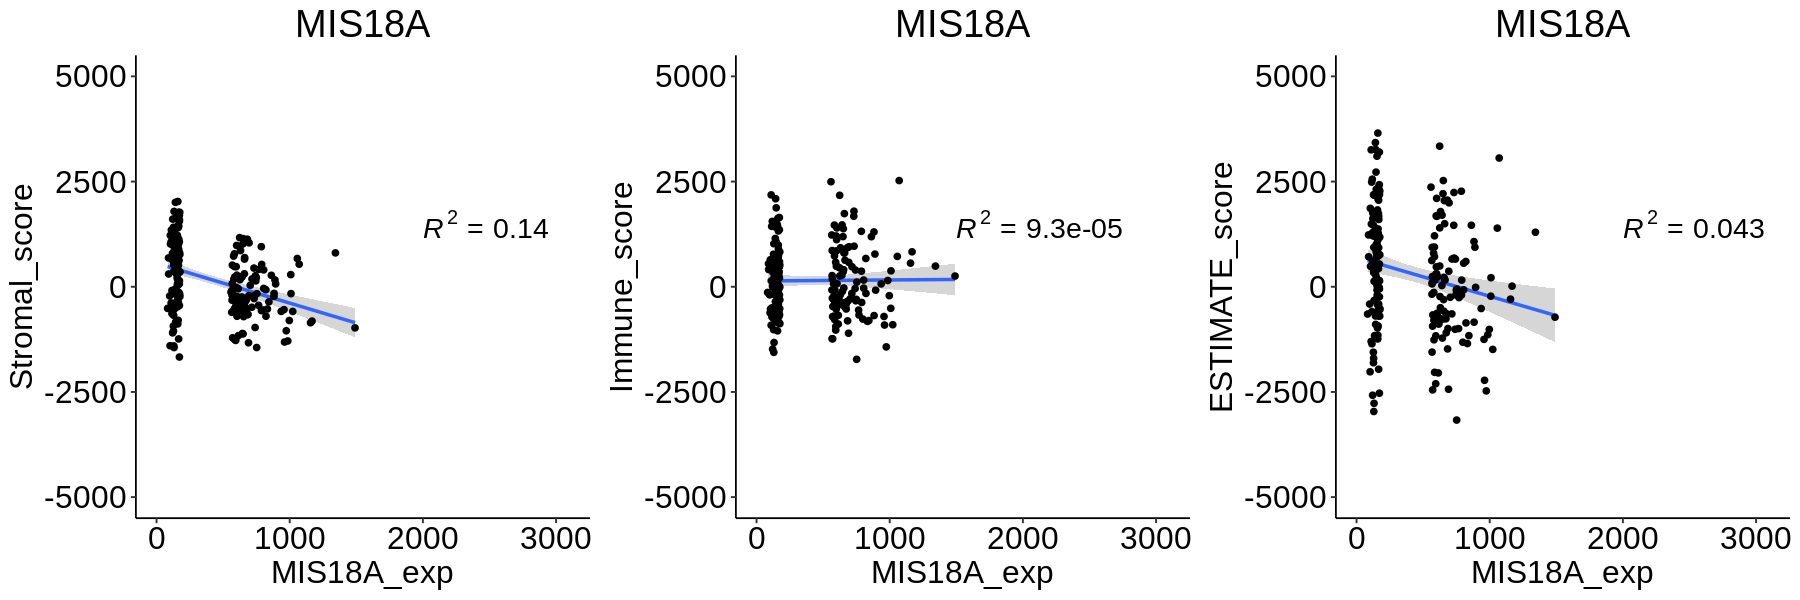

In [104]:
options(repr.plot.width=15, repr.plot.height=5)

plot1 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(MIS18A_q10_q90_quantile != 'neither') %>% select(MIS18A_exp, Stromal_score) %>% ggplot(aes(x = MIS18A_exp, y = Stromal_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 2000, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A')

plot2 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(MIS18A_q10_q90_quantile != 'neither') %>% select(MIS18A_exp, Immune_score) %>% ggplot(aes(x = MIS18A_exp, y = Immune_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 1500, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A')

plot3 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(MIS18A_q10_q90_quantile != 'neither') %>% select(MIS18A_exp, ESTIMATE_score) %>% ggplot(aes(x = MIS18A_exp, y = ESTIMATE_score)) + geom_smooth(method = "lm", formula = y ~ x) + geom_point() +
    stat_cor(aes(label = ..rr.label..), label.y = 1500, label.x = 2000, size = 6, method = 'pearson') + theme_pubr() + ylim(c(-5000, 5000)) + xlim(c(0, 3100)) +
    theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A')

ggarrange(plot1, plot2, plot3, ncol = 3)

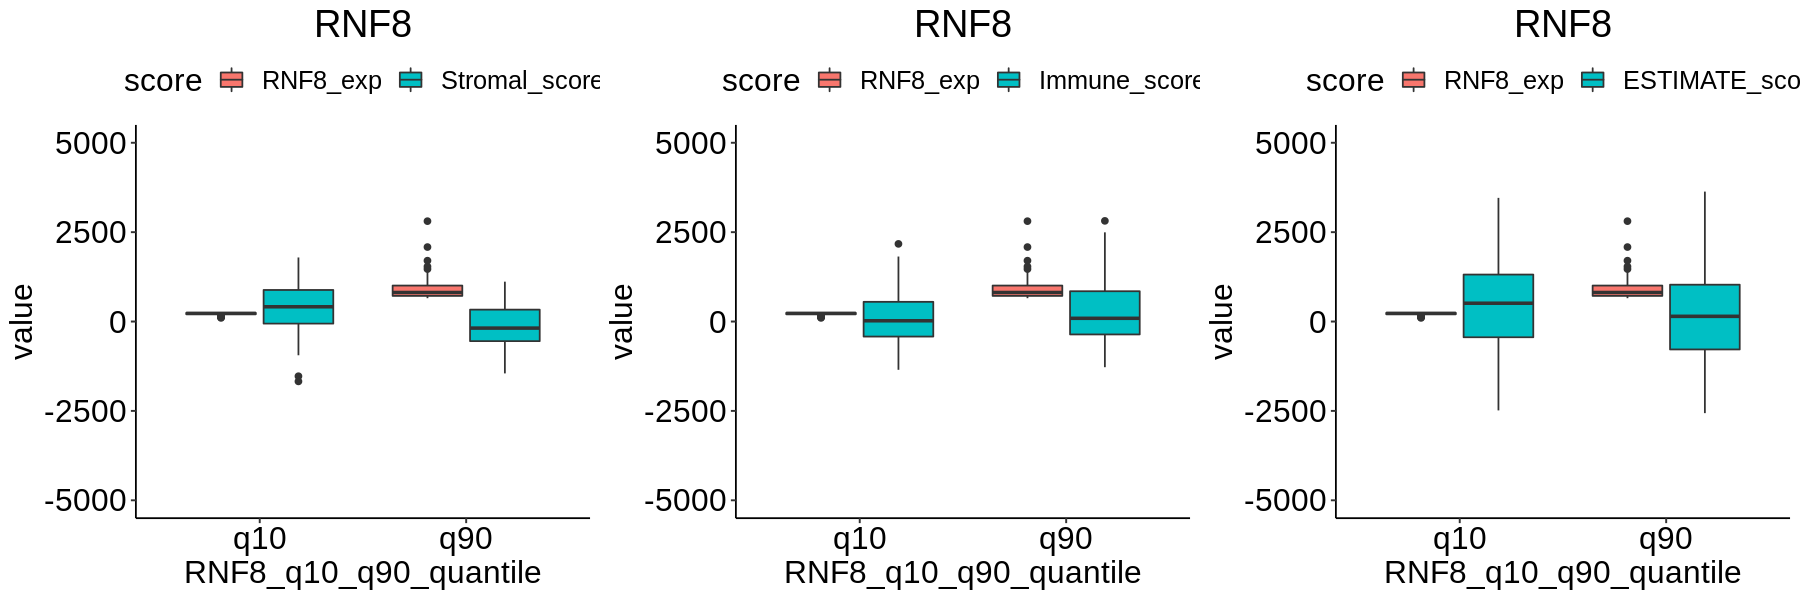

In [126]:
options(repr.plot.width=15, repr.plot.height=5)
plot1 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(RNF8_q10_q90_quantile != 'neither') %>% select(RNF8_exp, Stromal_score, RNF8_q10_q90_quantile) %>% pivot_longer(cols = -RNF8_q10_q90_quantile, names_to = 'score', values_to = 'value') %>% mutate(score = factor(score, levels = c('RNF8_exp', 'Stromal_score'))) %>% ggplot(aes(x = RNF8_q10_q90_quantile, y = value, fill = score)) + geom_boxplot() + theme_pubr() + theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8') + ylim(-5000, 5000)
plot2 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(RNF8_q10_q90_quantile != 'neither') %>% select(RNF8_exp, Immune_score, RNF8_q10_q90_quantile) %>% pivot_longer(cols = -RNF8_q10_q90_quantile, names_to = 'score', values_to = 'value') %>% mutate(score = factor(score, levels = c('RNF8_exp', 'Immune_score'))) %>% ggplot(aes(x = RNF8_q10_q90_quantile, y = value, fill = score)) + geom_boxplot() + theme_pubr() + theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8') + ylim(-5000, 5000)
plot3 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(RNF8_q10_q90_quantile != 'neither') %>% select(RNF8_exp, ESTIMATE_score, RNF8_q10_q90_quantile) %>% pivot_longer(cols = -RNF8_q10_q90_quantile, names_to = 'score', values_to = 'value') %>% mutate(score = factor(score, levels = c('RNF8_exp', 'ESTIMATE_score'))) %>% ggplot(aes(x = RNF8_q10_q90_quantile, y = value, fill = score)) + geom_boxplot() + theme_pubr() + theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('RNF8') + ylim(-5000, 5000)
ggarrange(plot1, plot2, plot3, ncol = 3)

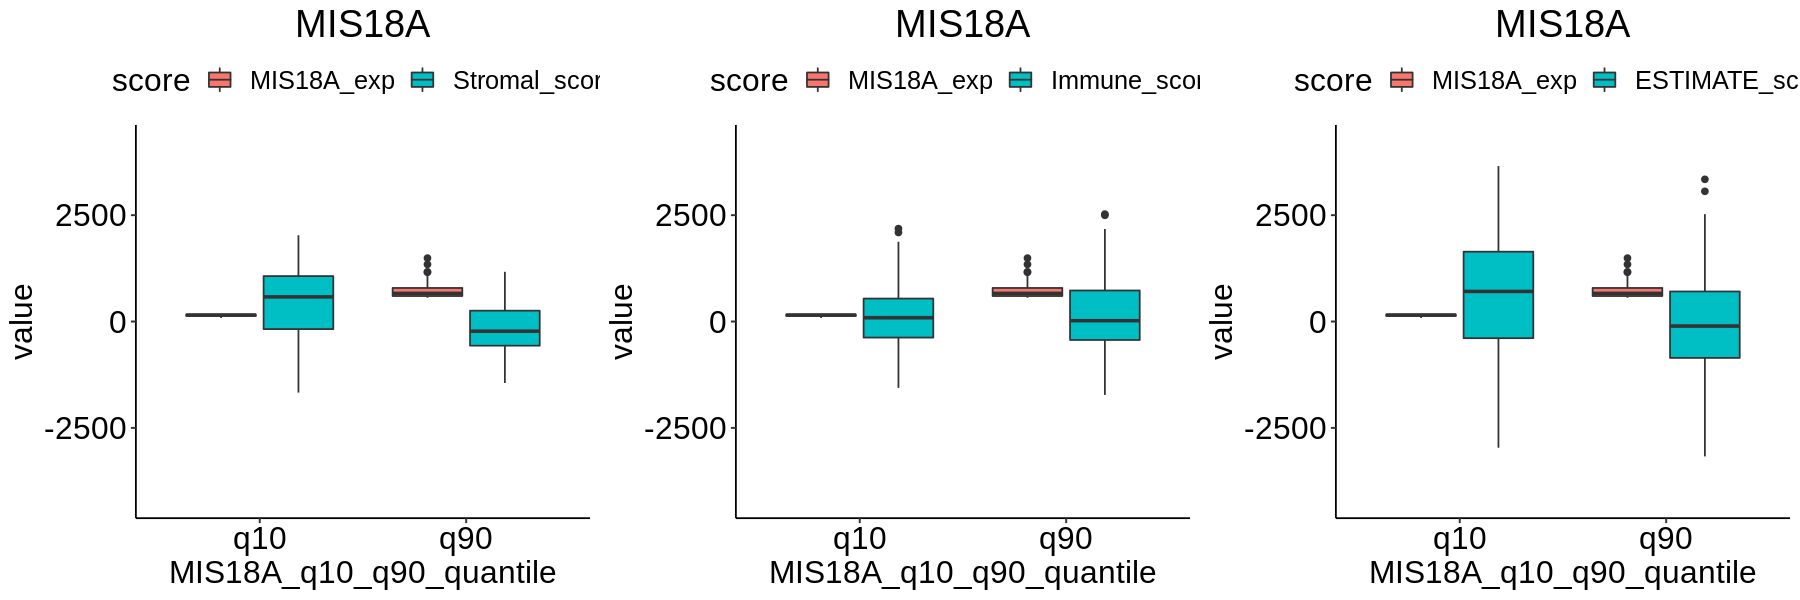

In [125]:
options(repr.plot.width=15, repr.plot.height=5)
plot1 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(MIS18A_q10_q90_quantile != 'neither') %>% select(MIS18A_exp, Stromal_score, MIS18A_q10_q90_quantile) %>% pivot_longer(cols = -MIS18A_q10_q90_quantile, names_to = 'score', values_to = 'value') %>% mutate(score = factor(score, levels = c('MIS18A_exp', 'Stromal_score'))) %>% ggplot(aes(x = MIS18A_q10_q90_quantile, y = value, fill = score)) + geom_boxplot() + theme_pubr() + theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A') + ylim(-4200, 4200)
plot2 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(MIS18A_q10_q90_quantile != 'neither') %>% select(MIS18A_exp, Immune_score, MIS18A_q10_q90_quantile) %>% pivot_longer(cols = -MIS18A_q10_q90_quantile, names_to = 'score', values_to = 'value') %>% mutate(score = factor(score, levels = c('MIS18A_exp', 'Immune_score'))) %>% ggplot(aes(x = MIS18A_q10_q90_quantile, y = value, fill = score)) + geom_boxplot() + theme_pubr() + theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A') + ylim(-4200, 4200)
plot3 = ESTIMATE_scores_w_CO_exp_and_quantiles %>% dplyr::filter(MIS18A_q10_q90_quantile != 'neither') %>% select(MIS18A_exp, ESTIMATE_score, MIS18A_q10_q90_quantile) %>% pivot_longer(cols = -MIS18A_q10_q90_quantile, names_to = 'score', values_to = 'value') %>% mutate(score = factor(score, levels = c('MIS18A_exp', 'ESTIMATE_score'))) %>% ggplot(aes(x = MIS18A_q10_q90_quantile, y = value, fill = score)) + geom_boxplot() + theme_pubr() + theme(text = element_text(size = 19), plot.title = element_text(hjust = 0.5)) + ggtitle('MIS18A') + ylim(-4200, 4200)
ggarrange(plot1, plot2, plot3, ncol = 3)